In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
import torch.nn.functional as F
from tqdm import tqdm 
from torchsummary import summary
from ptflops import get_model_complexity_info

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(248)
np.random.seed(248)
random.seed(248)
num_class = 3
learning_rate = 0.001
num_epochs = 100
batch_size = 32
dataset_class = ["battery", "metal", "plastic"]

cpu


In [3]:
#Tạo class để tiền xử lý ảnh
class ImageTransfrom():
  def __init__(self, resize, mean, std):
    self.data_transform = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(resize, scale = (0.5, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val': transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'test': transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }

  def __call__(self, img, phase= 'train'):
    return self.data_transform[phase](img)
  
def show_batch_with_labels(images, labels, classes = ["battery", "metal", "plastic"]):
    """
    Hiển thị từng ảnh trong một batch với nhãn tương ứng.
    
    Args:
        images (Tensor): Batch ảnh, kích thước [batch_size, 3, H, W].
        labels (Tensor): Batch nhãn, kích thước [batch_size].
        classes (list): Danh sách tên các lớp tương ứng với nhãn.
    """
    batch_size = images.size(0)  # Số lượng ảnh trong batch
    grid_size = int(batch_size**0.5)  # Kích thước lưới để hiển thị (vuông)
    
    images = images.permute(0, 2, 3, 1)  # Chuyển từ [B, C, H, W] sang [B, H, W, C]
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))  # Tạo lưới
    
    for i in range(grid_size * grid_size):
        ax = axes[i // grid_size, i % grid_size]
        
        if i < batch_size:  # Nếu còn ảnh để hiển thị
            img = images[i].numpy()
            img = (img - img.min()) / (img.max() - img.min())  # Chuẩn hóa về [0, 1]
            ax.imshow(img)
            ax.set_title(classes[labels[i].item()], fontsize=10)  # Thêm nhãn
        ax.axis("off")  # Tắt hiển thị khung trục
        
    plt.tight_layout()
    plt.show()

In [4]:
def compute_model_complexity(model, input_size=(3, 224, 224), device='cuda'):
    """
    Tính toán độ phức tạp mô hình (MACs, FLOPs) và số lượng tham số.

    Args:
        model (torch.nn.Module): Mô hình PyTorch.
        input_size (tuple): Kích thước đầu vào của mô hình (channel, height, width).
        device (str): Thiết bị để chạy mô hình, 'cuda' hoặc 'cpu'.
    Returns:
        None
    """
    # Đặt mô hình vào đúng thiết bị
    model = model.to(device)
    # Tính toán số phép toán (MACs) và số tham số
    macs, params = get_model_complexity_info(model, input_size, as_strings=True,
                                              print_per_layer_stat=True, verbose=True,
                                              flops_units='GMac')

    # Hiển thị thông tin về số phép toán và số tham số
    print('{:<30}  {:<8}'.format('Computational complexity (MACs): ', macs))
    
    # Tính toán FLOPs
    macs1 = macs.split()
    strmacs1 = str(float(macs1[0]) / 2) + ' ' + macs1[1][0]  # Chia đôi số MACs cho đúng với FLOPs
    print('{:<30}  {:<8}'.format('Floating-point operations (FLOPs): ', strmacs1))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))

    # Tính tổng số tham số trong mô hình
    total_params = sum([p.data.nelement() for p in model.parameters()])
    print('Number of model parameters (referred)): {}'.format(total_params))

    summary(model, input_size)

def train_net(net, train_loader, val_loader, num_epochs, learning_rate, path_to_save_model):
    """
    Huấn luyện một mạng nơ-ron với PyTorch, vẽ biểu đồ loss và lưu mô hình.
    Args:
        net (torch.nn.Module): Mô hình cần huấn luyện.
        train_loader (DataLoader): Bộ tải dữ liệu cho tập huấn luyện.
        val_loader (DataLoader): Bộ tải dữ liệu cho tập kiểm tra.
        num_epochs (int): Số epoch huấn luyện.
        learning_rate (float): Tốc độ học (learning rate).
        path_to_save_model (str): Đường dẫn tới folder lưu mô hình.
    
    Returns:
        dict: Lịch sử huấn luyện và kiểm tra (train_loss, val_loss).
    """
    # Chọn thiết bị (CPU/GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    history = {
        "train_loss": [],
        "val_loss": []
    }
    best_val_loss = float('inf')

    # Lấy tên của mạng để đặt tên cho file
    model_name = net.__class__.__name__

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        net.train()
        running_loss = 0.0

        # Huấn luyện mạng
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Tính loss huấn luyện
        train_loss = running_loss / len(train_loader)
        history["train_loss"].append(train_loss)

        # Kiểm tra trên tập validation
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validating"):
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        # Tính loss validation
        val_loss = val_loss / len(val_loader)
        history["val_loss"].append(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Lưu mô hình tốt nhất
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Tạo đường dẫn lưu mô hình và tên file
            model_save_path = f"{path_to_save_model}/{model_name}/{model_name}_best_model.pth"
            # Tạo thư mục nếu chưa tồn tại
            os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
            torch.save(net.state_dict(), model_save_path)
            print(f"Saved best model with Val Loss: {val_loss:.4f} to {model_save_path}")

    # Vẽ và lưu biểu đồ loss
    print("\nTraining completed. Saving loss plot...")
    model_save_path = f"{path_to_save_model}/{model_name}/{model_name}_best_modelv2.pth"
    # Tạo thư mục nếu chưa tồn tại
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(net.state_dict(), model_save_path)
    plt.figure(figsize=(10, 6))
    plt.plot(history["train_loss"], label="Train Loss", marker='o')
    plt.plot(history["val_loss"], label="Val Loss", marker='o')
    plt.title(f"{model_name} Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    
    # Tạo đường dẫn để lưu hình ảnh
    loss_plot_path = f"{path_to_save_model}/{model_name}/{model_name}_loss_plot.png"
    plt.savefig(loss_plot_path)
    plt.close()
    print(f"Loss plot saved as {loss_plot_path}")
    
    return history

def load_model(net, path_to_model, device=None):
    """
    Load tham số đã lưu vào mạng.
    Args:
        net (torch.nn.Module): Mạng cần tải tham số.
        path_to_model (str): Đường dẫn file chứa tham số đã lưu (.pth).
        device (torch.device, optional): Thiết bị để tải mô hình (CPU/GPU). 
                                         Nếu không được chỉ định, tự động chọn GPU nếu có.
    Returns:
        torch.nn.Module: Mạng với tham số đã tải.
    """
    if device is None:
        # Nếu không chỉ định thiết bị, tự động chọn GPU nếu có
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Chuyển mạng sang thiết bị được chỉ định (GPU hoặc CPU)
    net = net.to(device)
    
    try:
        # Tải tham số của mô hình từ file
        state_dict = torch.load(path_to_model, map_location=device)
        net.load_state_dict(state_dict)
        
        # Thông báo đã tải thành công mô hình
        print(f"Model loaded successfully from {path_to_model} on {device}.")
    except Exception as e:
        # Nếu có lỗi khi tải mô hình
        print(f"Error loading model from {path_to_model}: {e}")
    
    return net
    
def evaluate_model(model, test_dataloader, device='cuda'):
    """
    Hàm tính toán độ chính xác của mô hình trên bộ dữ liệu kiểm tra.

    Args:
        model (torch.nn.Module): Mô hình đã được huấn luyện.
        test_dataloader (DataLoader): Bộ dữ liệu kiểm tra.
        device (str): Thiết bị để chạy mô hình, 'cuda' hoặc 'cpu'.

    Returns:
        float: Độ chính xác của mô hình trên bộ dữ liệu kiểm tra.
    """
    # Đặt mô hình vào chế độ đánh giá (evaluation mode)
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():  # Không tính gradient trong quá trình đánh giá
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Tiến hành dự đoán với mô hình
            outputs = model(images)
            
            # Lấy ra dự đoán có giá trị lớn nhất
            _, predicted = torch.max(outputs.data, 1)
            
            # Tính tổng số lượng mẫu và số lượng dự đoán đúng
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Tính độ chính xác và in ra kết quả
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy:.2f}%')
    return accuracy

def evaluate_model_per_class(model, test_dataloader, classes, device='cuda'):
    """
    Hàm tính toán độ chính xác của mô hình trên từng lớp của bộ dữ liệu kiểm tra.

    Args:
        model (torch.nn.Module): Mô hình đã được huấn luyện.
        test_dataloader (DataLoader): Bộ dữ liệu kiểm tra.
        num_classes (int): Số lượng lớp trong bài toán phân loại.
        device (str): Thiết bị để chạy mô hình, 'cuda' hoặc 'cpu'.

    Returns:
        dict: Độ chính xác của từng lớp dưới dạng dictionary.
    """
    # Đặt mô hình vào chế độ đánh giá (evaluation mode)
    num_classes = len(classes)
    model.eval()
    correct_per_class = [0] * num_classes  # Số lượng dự đoán đúng cho từng lớp
    total_per_class = [0] * num_classes    # Tổng số mẫu cho từng lớp
    
    with torch.no_grad():  # Không tính gradient trong quá trình đánh giá
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Tiến hành dự đoán với mô hình
            outputs = model(images)
            
            # Lấy ra dự đoán có giá trị lớn nhất
            _, predicted = torch.max(outputs.data, 1)
            
            # Cập nhật số lượng đúng và tổng số mẫu cho từng lớp
            for label, prediction in zip(labels, predicted):
                total_per_class[label.item()] += 1
                if label == prediction:
                    correct_per_class[label.item()] += 1

    # Tính độ chính xác cho từng lớp
    class_accuracies = {
        f'{classes[i]}': (100 * correct / total if total > 0 else 0.0)
        for i, (correct, total) in enumerate(zip(correct_per_class, total_per_class))
    }

    # In kết quả
    for class_name, accuracy in class_accuracies.items():
        print(f'{class_name}: {accuracy:.2f}%')

    return class_accuracies


In [5]:
resize = 224
mean = (0.485, 0.456, 0.406) # Search gg "mean std imagenet"
std = (0.229, 0.224, 0.225)
transform_image = ImageTransfrom(resize, mean, std)

In [6]:
train_path = "./garbage_classification_3/Train" # "/content/drive/MyDrive/ML_Final/garbage_classification/Train"  # ae chạy trên máy hay tải lên colab chạy thì chỉnh path cho đúng
test_path = "./garbage_classification_3/Test" #  "/content/drive/MyDrive/ML_Final/garbage_classification/Test"
val_path = "./garbage_classification_3/Val" # "/content/drive/MyDrive/ML_Final/garbage_classification/Val"

In [7]:
train_dataset = datasets.ImageFolder(
    root=train_path,
    transform=lambda img: transform_image(img, phase="train")
)
test_dataset = datasets.ImageFolder(
    root=test_path,
    transform=lambda img: transform_image(img, phase="test")
)
val_dataset = datasets.ImageFolder(
    root=val_path,
    transform=lambda img: transform_image(img, phase="val")
)

In [8]:
print("Total image train:", len(train_dataset))
print("Total image val:", len(val_dataset))
print("Total image test:", len(test_dataset))

Total image train: 2920
Total image val: 300
Total image test: 300


In [9]:
img0, label = train_dataset.__getitem__(400)
print("Image size: ",img0.shape)
print("Image label: ", label)

Image size:  torch.Size([3, 224, 224])
Image label:  0


In [10]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True) # train_dataloader dùng để train
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle = False) # val_dataloader dùng để đánh giá trong lúc train
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle = False) # test_dataloader dùng để test sau khi train

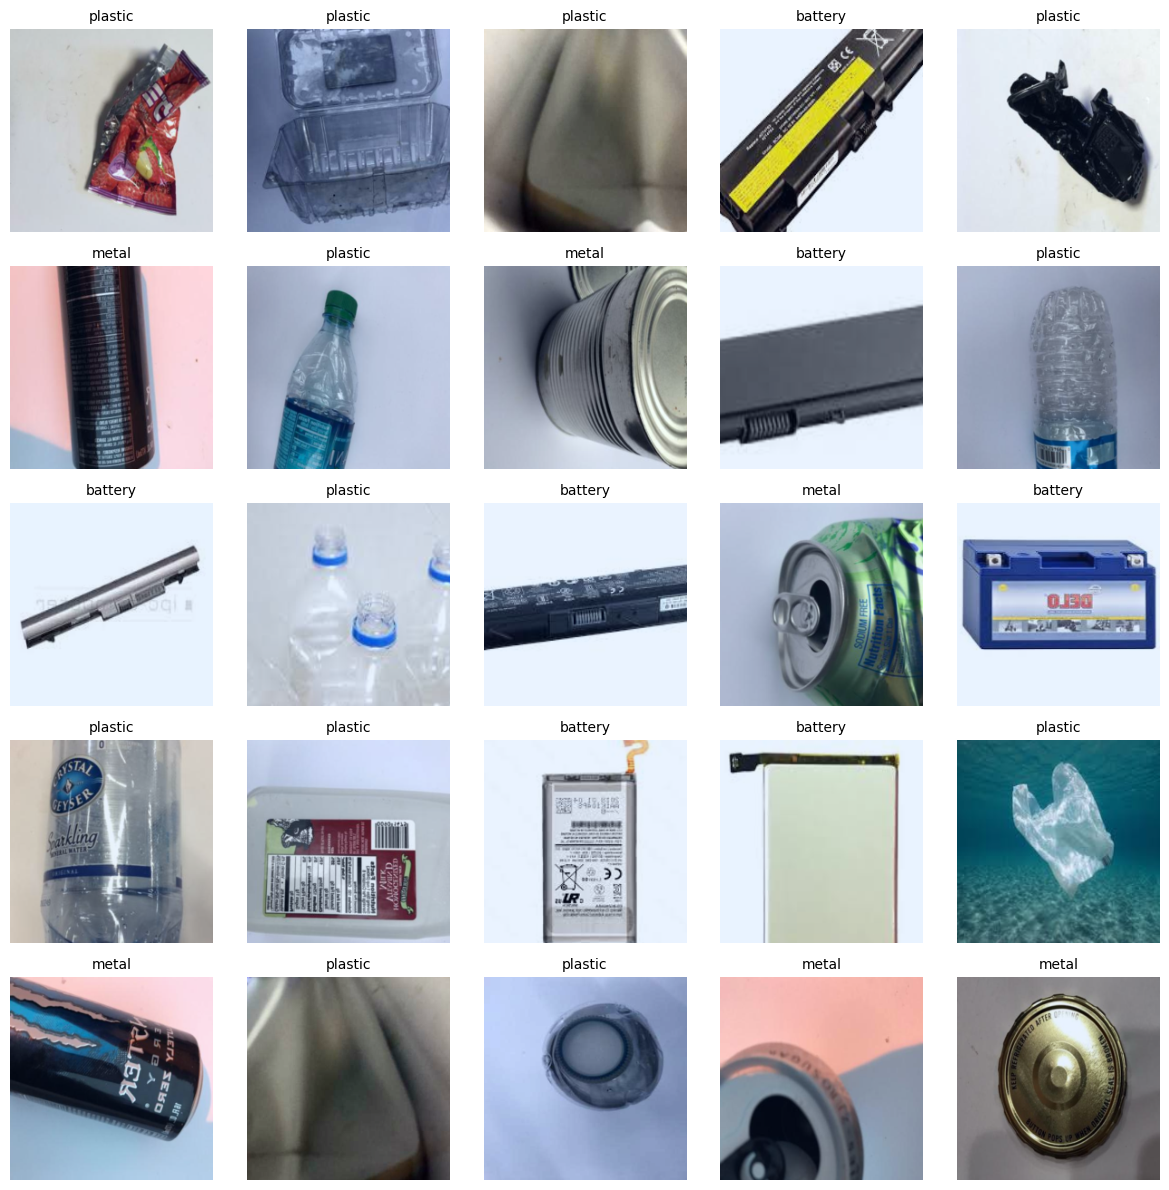

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [11]:
dataset_class = ["battery", "metal", "plastic"]
batch_iterator =  iter(train_dataloader)
inputs, labels = next(batch_iterator)
show_batch_with_labels(inputs, labels, dataset_class)
print(inputs.shape, labels.shape)

## Mạng 01: 
Thiết kế thêm ít nhất:
- 10 conv3x3(), 01 maxpooling(.), 02 avgpooling(.), 02 torch.cat(.), 02 phép cộng 2 tensors, và 02 fully connected layer (FC(.)). 
- Số lượng parameter từ khoảng 10M to 20M.

Kết quả nhóm 6 đạt được mạng 1:
- Number of parameters: 11.02M
- FLOPs: 0.69G
- Top-1 accuracy: 91.67%

In [12]:
class Nhom6Net1(nn.Module):
    def __init__(self, inChanels, num_class):
        super(Nhom6Net1, self).__init__()
        self.conv = nn.Conv2d(in_channels= inChanels, out_channels= 32, kernel_size= 7, padding= 3, stride= 1)
        
        self.conv1 = nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size=3, padding= 1, stride= 2)
        self.conv2 = nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size=3, padding= 1, stride= 1)
        self.conv3 = nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size=3, padding= 1, stride= 1)
        self.conv4 = nn.Conv2d(in_channels= 64, out_channels= 92, kernel_size=3, padding= 1, stride= 2)
        self.conv5 = nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size=3, padding= 1, stride= 1)
        self.conv6 = nn.Conv2d(in_channels= 92, out_channels= 192, kernel_size=3, padding= 1, stride= 1)
        self.conv7 = nn.Conv2d(in_channels= 192, out_channels= 224, kernel_size=3, padding= 1, stride= 2)
        
        self.conv8 = nn.Conv2d(in_channels= 128, out_channels= 32, kernel_size=3, padding= 1, stride= 1)
        self.conv9 = nn.Conv2d(in_channels= 224, out_channels= 256, kernel_size=3, padding= 1, stride= 2)
        self.conv10 = nn.Conv2d(in_channels= 256, out_channels= 512, kernel_size=3, padding= 1, stride= 2)
        
        self.conv11 = nn.Conv2d(in_channels= 128, out_channels= 64, kernel_size=1)
        self.conv12 = nn.Conv2d(in_channels= 92, out_channels= 64, kernel_size=1)
        self.conv13 = nn.Conv2d(in_channels= 128, out_channels= 92, kernel_size=1)
        self.conv14 = nn.Conv2d(in_channels= 192, out_channels= 128, kernel_size=1)
        
        self.fc1 = nn.Linear(8192, 1024)
        self.fc2 = nn.Linear(1024, num_class)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size = 2)

        x1 = F.relu(self.conv2(x))
        x2 = F.relu(self.conv11(x1))
        x2 = F.relu(self.conv3(x2))
        x2 = x2 + x1
        x2 = torch.cat((x, x2), dim = 1)
        x2 = F.max_pool2d(x2, kernel_size= 2)

        x3 = F.relu(self.conv4(x))
        x3 = F.relu(self.conv12(x3))
        x3 = F.relu(self.conv5(x3))
        x3 = F.relu(self.conv13(x3))
        x3 = F.relu(self.conv6(x3))
        x3 = x3 + x2

        x4 = F.relu(self.conv14(x3))
        x4 = F.relu(self.conv8(x4))        
        x4 = torch.cat((x3, x4), dim = 1)
        x4 = F.avg_pool2d(x4, kernel_size = 2)
        x5 = F.relu(self.conv7(x3))
        x5 = x5 + x4

        x5 = F.relu(self.conv9(x5))
        x5 = F.relu(self.conv10(x5))

        x5 = x5.view(-1, 8192)
        x5 = self.fc1(x5)
        x5 = self.dropout(x5)
        x5 = self.fc2(x5)
        return x5

In [13]:
Net1_training = Nhom6Net1(inChanels = 3, num_class= num_class)
compute_model_complexity(Net1_training, device=device)

Nhom6Net1(
  11.02 M, 100.000% Params, 1.37 GMac, 99.592% MACs, 
  (conv): Conv2d(4.74 k, 0.043% Params, 0.24 GMac, 17.227% MACs, 3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv1): Conv2d(18.5 k, 0.168% Params, 0.23 GMac, 16.819% MACs, 32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(73.86 k, 0.670% Params, 0.23 GMac, 16.790% MACs, 64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(73.86 k, 0.670% Params, 0.23 GMac, 16.790% MACs, 64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(53.08 k, 0.482% Params, 0.04 GMac, 3.017% MACs, 64, 92, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(73.86 k, 0.670% Params, 0.06 GMac, 4.198% MACs, 64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(159.17 k, 1.444% Params, 0.12 GMac, 9.046% MACs, 92, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(387.3 k, 3.514% Params, 0.08 GMac, 5.

In [14]:
# Ô này dùng để training
# path_to_save_model = "./models" # "/content/drive/MyDrive/ML_Final/models" # chỉnh path cho đúng nha
# history = train_net(
#     Net1_training, 
#     train_dataloader, 
#     val_dataloader, 
#     num_epochs= 100, # thầy yêu cầu epoch từ 20 - 100 nha
#     learning_rate= learning_rate, 
#     path_to_save_model= path_to_save_model
# )

In [15]:
path_to_save_model = "./models"
net1 = Nhom6Net1(inChanels = 3, num_class= num_class)
path_model_trained = f"{path_to_save_model}/Nhom6Net1/Nhom6Net1_best_model.pth" # Chỉnh cho đúng đường dẫn 
net1 = load_model(net1, path_model_trained, device=device)
evaluate_model(net1, test_dataloader, device= device)
evaluate_model_per_class(net1, test_dataloader, classes = dataset_class, device=device)

Model loaded successfully from ./models/Nhom6Net1/Nhom6Net1_best_model.pth on cpu.
Accuracy of the network on the test images: 91.67%
battery: 92.00%
metal: 88.00%
plastic: 95.00%


{'battery': 92.0, 'metal': 88.0, 'plastic': 95.0}

## Mạng 02: 
Thiết kế thêm ít nhất:
-  10 conv5x5(), 02 maxpooling(.), 01 avgpooling(.), 01 torch.cat(.), 02 phép cộng 2 tensors, và 01 fully connected layer (FC(.)). 
- Số lượng parameter từ khoảng 10M to 20M.

Kết quả nhóm 6 đạt được mạng 2:
- Number of parameters: 10.29M
- FLOPs: 1.745G
- Top-1 accuracy: 91.33%

In [16]:
class Nhom6Net2(nn.Module):
    def __init__(self, inChanels, num_class):
        super(Nhom6Net2, self).__init__()
        self.conv = nn.Conv2d(in_channels= inChanels, out_channels= 32, kernel_size= 7, padding= 3, stride= 1)
        
        self.conv1 = nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size=5, padding= 2, stride= 2)
        self.conv2 = nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size=5, padding= 2, stride= 1)
        self.conv3 = nn.Conv2d(in_channels= 64, out_channels= 32, kernel_size=5, padding= 2, stride= 1)
        self.conv4 = nn.Conv2d(in_channels= 96, out_channels= 128, kernel_size=5, padding= 2, stride= 2)
        self.conv5 = nn.Conv2d(in_channels= 96, out_channels= 128, kernel_size=5, padding= 2, stride= 1)
        self.conv6 = nn.Conv2d(in_channels= 128, out_channels= 256, kernel_size=5, padding= 2, stride= 2)
        self.conv7 = nn.Conv2d(in_channels= 128, out_channels= 256, kernel_size=5, padding= 2, stride= 1)
        
        self.conv8 = nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size=5, padding= 2, stride= 2)
        self.conv9 = nn.Conv2d(in_channels= 128, out_channels= 256, kernel_size=5, padding= 2, stride= 2)
        self.conv10 = nn.Conv2d(in_channels= 256, out_channels= 512, kernel_size=5, padding= 2, stride= 1)
        self.conv11 = nn.Conv2d(in_channels= 128, out_channels= 64, kernel_size=1)
        
        self.fc1 = nn.Linear(3072, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, num_class)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size = 2)
        x1 = F.relu(self.conv2(x))
        x1 = F.relu(self.conv11(x1))
        x1 = F.relu(self.conv3(x1))
        x2 = torch.cat((x, x1), dim = 1)
        x3 = F.max_pool2d(x2, kernel_size= 2)
        x3 = F.relu(self.conv5(x3))
        x4 = F.relu(self.conv4(x2))
        x5 = x3 + x4
        x6 = F.relu(self.conv6(x5))
        x7 = F.avg_pool2d(x5, kernel_size = 2)
        x7 = F.relu(self.conv7(x7))
        x8 = x6 + x7

        x9 = F.relu(self.conv8(x))
        x9 = F.relu(self.conv9(x9))
        x9 = F.relu(self.conv10(x9))
        
        x10 = torch.cat((x8, x9), dim = 1)
        x10 = F.avg_pool2d(x10, kernel_size= 7)
        x10 = x10.view(-1, 3072)
        x10 = self.fc1(x10)
        x10 = self.dropout(x10)
        x10 = self.fc2(x10)
        x10 = self.fc3(x10)
        return x10

In [17]:
Net2_training = Nhom6Net2(inChanels = 3, num_class= num_class)
compute_model_complexity(Net2_training, device=device)

Nhom6Net2(
  10.29 M, 100.000% Params, 3.48 GMac, 99.856% MACs, 
  (conv): Conv2d(4.74 k, 0.046% Params, 0.24 GMac, 6.819% MACs, 3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv1): Conv2d(51.26 k, 0.498% Params, 0.64 GMac, 18.452% MACs, 32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(204.93 k, 1.992% Params, 0.64 GMac, 18.440% MACs, 64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(51.23 k, 0.498% Params, 0.16 GMac, 4.610% MACs, 64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(307.33 k, 2.988% Params, 0.24 GMac, 6.914% MACs, 96, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv5): Conv2d(307.33 k, 2.988% Params, 0.24 GMac, 6.914% MACs, 96, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv6): Conv2d(819.46 k, 7.967% Params, 0.16 GMac, 4.609% MACs, 128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv7): Conv2d(819.46 k, 7.967% Params, 0.16 GMac

In [18]:
# Ô này để training
# path_to_save_model = "./models" # "/content/drive/MyDrive/ML_Final/models" # chỉnh path cho đúng nha
# history = train_net(
#     Net2_training, 
#     train_dataloader, 
#     val_dataloader, 
#     num_epochs= 100, # thầy yêu cầu epoch từ 20 - 100 nha
#     learning_rate= learning_rate, 
#     path_to_save_model= path_to_save_model
# )

In [19]:
path_to_save_model = "./models"
net2 = Nhom6Net2(inChanels = 3, num_class= num_class)
path_model_trained = f"{path_to_save_model}/Nhom6Net2/Nhom6Net2_best_model.pth" # Chỉnh cho đúng đường dẫn 
net2 = load_model(net2, path_model_trained, device=device)
evaluate_model(net2, test_dataloader, device= device)
evaluate_model_per_class(net2, test_dataloader, classes = dataset_class, device=device)

Model loaded successfully from ./models/Nhom6Net2/Nhom6Net2_best_model.pth on cpu.
Accuracy of the network on the test images: 91.33%
battery: 86.00%
metal: 97.00%
plastic: 91.00%


{'battery': 86.0, 'metal': 97.0, 'plastic': 91.0}

## Mạng 03: 
Thiết kế thêm ít nhất:
-  10 conv3x3(), 10 conv5x5(), 02 maxpooling(.), 02 avgpooling(.), 04 torch.cat(.), 04 phép cộng 2 tensors, và 02 fully connected layer (FC(.)). 
- Số lượng parameter từ khoảng 10M to 20M.

Kết quả nhóm 6 đạt được mạng 3:
- Number of parameters: 13.32M
- FLOPs: 2.42G
- Top-1 accuracy: 93.33%

In [20]:
class Nhom6Net3(nn.Module):
    def __init__(self, inChanels, num_class):
        super(Nhom6Net3, self).__init__()
        self.conv = nn.Conv2d(in_channels= inChanels, out_channels= 32, kernel_size= 7, padding= 3, stride= 1)
        self.conv1 = nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size=5, padding= 2, stride= 2)

        self.conv2 = nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size=3, padding= 1, stride= 1)
        self.conv3 = nn.Conv2d(in_channels= 128, out_channels= 64, kernel_size=1, padding= 0, stride= 1)
        self.conv4 = nn.Conv2d(in_channels= 64, out_channels= 256, kernel_size=3, padding= 1, stride= 1)
        self.conv5 = nn.Conv2d(in_channels= 64, out_channels= 256, kernel_size=5, padding= 2, stride= 1)
        self.conv6 = nn.Conv2d(in_channels= 256, out_channels= 128, kernel_size=1, padding= 0, stride= 1)
        self.conv7 = nn.Conv2d(in_channels= 128, out_channels= 64, kernel_size=5, padding= 2, stride= 1)

        self.conv8 = nn.Conv2d(in_channels= 128, out_channels= 192, kernel_size=3, padding= 1, stride= 1)
        self.conv9 = nn.Conv2d(in_channels= 192, out_channels= 64, kernel_size=1, padding= 0, stride= 1)
        self.conv10 = nn.Conv2d(in_channels= 64, out_channels= 256, kernel_size=3, padding= 1, stride= 1)
        self.conv11 = nn.Conv2d(in_channels= 64, out_channels= 256, kernel_size=5, padding= 2, stride= 1)
        self.conv12 = nn.Conv2d(in_channels= 256, out_channels= 128, kernel_size=1, padding= 0, stride= 1)
        self.conv13 = nn.Conv2d(in_channels= 128, out_channels= 64, kernel_size=5, padding= 2, stride= 1)

        self.conv14 = nn.Conv2d(in_channels= 192, out_channels= 256, kernel_size=3, padding= 1, stride= 1)
        self.conv15 = nn.Conv2d(in_channels= 256, out_channels= 64, kernel_size=1, padding= 0, stride= 1)
        self.conv16 = nn.Conv2d(in_channels= 64, out_channels= 256, kernel_size=3, padding= 1, stride= 1)
        self.conv17 = nn.Conv2d(in_channels= 64, out_channels= 256, kernel_size=5, padding= 2, stride= 1)
        self.conv18 = nn.Conv2d(in_channels= 256, out_channels= 128, kernel_size=1, padding= 0, stride= 1)
        self.conv19 = nn.Conv2d(in_channels= 128, out_channels= 64, kernel_size=5, padding= 2, stride= 1)

        self.conv20 = nn.Conv2d(in_channels= 256, out_channels= 320, kernel_size=3, padding= 1, stride= 1)
        self.conv21 = nn.Conv2d(in_channels= 320, out_channels= 64, kernel_size=1, padding= 0, stride= 1)
        self.conv22 = nn.Conv2d(in_channels= 64, out_channels= 256, kernel_size=3, padding= 1, stride= 1)
        self.conv23 = nn.Conv2d(in_channels= 64, out_channels= 256, kernel_size=5, padding= 2, stride= 1)
        self.conv24 = nn.Conv2d(in_channels= 256, out_channels= 128, kernel_size=1, padding= 0, stride= 1)
        self.conv25 = nn.Conv2d(in_channels= 128, out_channels= 64, kernel_size=5, padding= 2, stride= 1)

        self.conv26 = nn.Conv2d(in_channels= 320, out_channels= 384, kernel_size=3, padding= 0, stride= 1)
        self.conv27 = nn.Conv2d(in_channels= 384, out_channels= 448, kernel_size=3, padding= 1, stride= 1)
        self.conv28 = nn.Conv2d(in_channels= 448, out_channels= 512, kernel_size=5, padding= 0, stride= 1)

        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_class)
        self.dropout = nn.Dropout(p=0.5)
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size= 2)

        x1 = F.relu(self.conv2(x))
        x1 = F.relu(self.conv3(x1))
        x2 = F.relu(self.conv4(x1))
        x3 = F.relu(self.conv5(x1))
        x3 = x3 + x2
        x3 = F.relu(self.conv6(x3))
        x3 = F.relu(self.conv7(x3))
        x3 = torch.cat((x3, x), dim = 1)
        x3 = F.avg_pool2d(x3, kernel_size=2)

        x4 = F.relu(self.conv8(x3))
        x4 = F.relu(self.conv9(x4))
        x5 = F.relu(self.conv10(x4))
        x6 = F.relu(self.conv11(x4))
        x6 = x6 + x5
        x6 = F.relu(self.conv12(x6))
        x6 = F.relu(self.conv13(x6))
        x6 = torch.cat((x6, x3), dim = 1)
        x6 = F.max_pool2d(x6, kernel_size=2)

        x7 = F.relu(self.conv14(x6))
        x7 = F.relu(self.conv15(x7))
        x8 = F.relu(self.conv16(x7))
        x9 = F.relu(self.conv17(x7))
        x9 = x8 + x9
        x9 = F.relu(self.conv18(x9))
        x9 = F.relu(self.conv19(x9))
        x9 = torch.cat((x6, x9), dim = 1)
        x9 = F.avg_pool2d(x9, kernel_size=2)

        x10 = F.relu(self.conv20(x9))
        x10 = F.relu(self.conv21(x10))
        x11 = F.relu(self.conv22(x10))
        x12 = F.relu(self.conv23(x10))
        x12 = x11 + x12
        x12 = F.relu(self.conv24(x12))
        x12 = F.relu(self.conv25(x12))
        x12 = torch.cat((x12, x9), dim = 1)

        x12 = F.relu(self.conv26(x12))
        x12 = F.relu(self.conv27(x12))
        x12 = F.relu(self.conv28(x12))

        x12 = x12.view(-1, 512)
        x12 = self.fc1(x12)
        x12 = self.dropout(x12)
        x12 =  self.fc2(x12)
        x12 =  self.fc3(x12)

        return x12

In [21]:
Net3_training = Nhom6Net3(inChanels = 3, num_class= num_class)
compute_model_complexity(Net3_training, device=device)

Nhom6Net3(
  13.32 M, 100.000% Params, 4.83 GMac, 99.842% MACs, 
  (conv): Conv2d(4.74 k, 0.036% Params, 0.24 GMac, 4.909% MACs, 3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv1): Conv2d(51.26 k, 0.385% Params, 0.64 GMac, 13.283% MACs, 32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(73.86 k, 0.554% Params, 0.23 GMac, 4.784% MACs, 64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8.26 k, 0.062% Params, 0.03 GMac, 0.535% MACs, 128, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(147.71 k, 1.109% Params, 0.46 GMac, 9.569% MACs, 64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(409.86 k, 3.076% Params, 1.29 GMac, 26.550% MACs, 64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv6): Conv2d(32.9 k, 0.247% Params, 0.1 GMac, 2.131% MACs, 256, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv7): Conv2d(204.86 k, 1.537% Params, 0.64 GMac, 13.271% MACs, 128, 64, kernel_size

In [22]:
# Ô này để training
# path_to_save_model = "./models" # "/content/drive/MyDrive/ML_Final/models" # chỉnh path cho đúng nha
# history = train_net(
#     Net3_training, 
#     train_dataloader, 
#     val_dataloader, 
#     num_epochs= 50, # thầy yêu cầu epoch từ 20 - 100 nha
#     learning_rate= learning_rate, 
#     path_to_save_model= path_to_save_model
# )

In [23]:
net3 = Nhom6Net3(inChanels = 3, num_class= num_class)
path_model_trained = f"{path_to_save_model}/Nhom6Net3/Nhom6Net3_best_modelv2.pth" # Chỉnh cho đúng đường dẫn 
net3 = load_model(net3, path_model_trained, device=device)
evaluate_model(net3, test_dataloader, device= device)
evaluate_model_per_class(net3, test_dataloader, classes = dataset_class, device=device)

Model loaded successfully from ./models/Nhom6Net3/Nhom6Net3_best_modelv2.pth on cpu.
Accuracy of the network on the test images: 93.33%
battery: 93.00%
metal: 90.00%
plastic: 97.00%


{'battery': 93.0, 'metal': 90.0, 'plastic': 97.0}